<a href="https://colab.research.google.com/github/ailsonramon/Mathematical_Modeling/blob/main/TS_daily_analysis_energy_2000_2021_Brazillian_Northeast_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução a séries temporais

Uma série temporal é definida como um conjunto de valores que se modificam em intervalos iguais de tempo. 

Exemplo
* Valor de ativos na bolsa de valores
* População de um pais
* Quantidades de passageiros 

Os modelos utilizados para descrever séries temporais são **processos estocásticos**, isto é, processos controlados por leis probabilísticas. 

#Importação das libs e dataset

In [100]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

# melhorar a visualização
pd.set_option('max_columns',170)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:

  #importa o dataset para um Dataframe
col_list = ["Data Escala de Tempo 1 DM Simp 4","Selecione Tipo de DM Simp 4"]
time = "Data Escala de Tempo 1 DM Simp 4"
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M') 
ts = pd.read_csv('/content/drive/Shareddrives/Modelagem_Analitica/Ailson/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv'
     ,usecols=col_list)#, squeeze=True)

#transformar csv
#fazer as abordagens inicias da serie temporal
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Data Escala de Tempo 1 DM Simp 4  7701 non-null   object 
 1   Selecione Tipo de DM Simp 4       7701 non-null   float64
dtypes: float64(1), object(1)
memory usage: 120.5+ KB


In [51]:
print(len(ts))

7701


In [29]:
#tratamento de dados via shell
%%shell
cut -d, -f2-7 --complement /content/drive/Shareddrives/Modelagem_Analitica/Ailson/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv > timeserie.csv
sed -i '1 d' timeserie.csv
sed -i  's/12:00:00 AM//g; s/1:00:00 AM//g' timeserie.csv
sed -i 's/ ,/,/g' timeserie.csv



In [45]:
ts_csv = pd.read_csv("/content/timeserie.csv", index_col=0)
ts_csv.info()
ts_csv.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7700 entries, 1/2/2000 to 1/31/2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6205    7700 non-null   float64
dtypes: float64(1)
memory usage: 120.3+ KB


,6205
1/1/2000,
1/2/2000,6797.0
1/3/2000,7024.0
1/4/2000,6921.0
1/5/2000,7025.0
1/6/2000,6881.0


In [71]:
type(ts_csv)

pandas.core.frame.DataFrame

In [49]:
dateparse = lambda dates: datetime.strptime(dates, '%m/%d/%Y') 
ts_format = pd.read_csv('timeserie.csv', parse_dates=True, index_col=0,date_parser=dateparse, squeeze=True) 
type(ts_format)

pandas.core.series.Series

In [48]:
print(len(ts_format))

7700


In [68]:
ts_format.head()

1/1/2000
2000-01-02    6797.0
2000-01-03    7024.0
2000-01-04    6921.0
2000-01-05    7025.0
2000-01-06    6881.0
Name: 6205, dtype: float64

In [40]:
type(ts_format)

pandas.core.series.Series

In [41]:
ts.index

RangeIndex(start=0, stop=7701, step=1)

#Análise exploratória dos dados

Análise do gráfico

Total data:3850


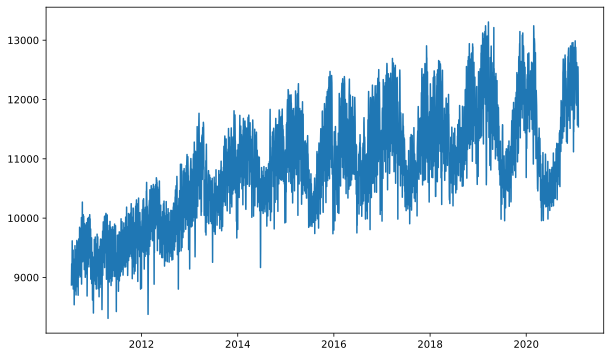

In [77]:
#Select a percentage from the time series
data_proportion = lambda serie, percent=1.0: serie[-int(percent * len(serie)):]
ts_50_per = data_proportion(ts_format, percent=0.50)
print(f'Total data:{len(ts_50_per)}')
plt.rcParams["figure.figsize"] = [10,6]
plt.plot(ts_50_per)

In [79]:
type(ts_50_per)

pandas.core.series.Series

Total of Date:77


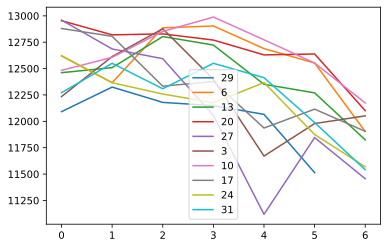

In [96]:
def weekly_plot(serie):
  groups = serie[8:].groupby(pd.Grouper(freq='W'))
  values = list()
  days = list()
  for name, group in groups:
    df = pd.DataFrame(group.values)
    values.append(df)
    days.append(name.day)
  df = pd.concat(values, ignore_index=True, axis=1)
  df.columns = days
  df.plot(subplots=False, legend=True)
  #df.()

ts_01_per = data_proportion(ts_format, percent=0.01)
print(f'Total of Date:{len(ts_01_per)}')
weekly_plot(ts_01_per)

#Distribuição de Frequência


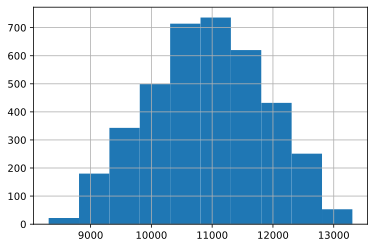

In [67]:
ts_50_per.hist()
plt.rcParams["figure.figsize"] = [1,1]
plt.show()

O Histograma apresenta uma distribuição gaussiana, indicando que a série é estacionária.

#Característica estatísticas

In [98]:
X = ts_50_per
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()

var1, var2 = X1.var(), X2.var()
print("Media da primeira parte: %f, \nMedia da segunda parte:%f" %(mean1, mean2))
#print(f"variancia1:{var1} \nvariancia2:{var2}")
print("Variancia1:%f\nVariancia2:%f" % (var1,var2))

Media da primeira parte: 10331.358625, 
Media da segunda parte:11496.474248
Variancia1:614193.696174
Variancia2:527129.149157


Tanto a média quanto a variância contém pouca variação entre as metades das amostras. 
Isso também indica que a série é estacionária

In [101]:
def plot_mean_var_ts(timeseries):
  #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=240).mean()
    rolstd = pd.Series(timeseries).rolling(window=240).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [102]:
def test_dickfuller(timeseries):
  #Reference:https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
  result = adfuller(x=timeseries,autolag='AIC')
  dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  print('ADF   statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

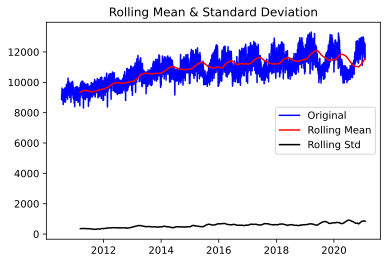

Results of Dickey-Fuller Test:
ADF Statistic                    -2.935432
p-value                           0.041380
#Lags Used                       30.000000
Number of Observations Used    3819.000000
Critical Value (1%)              -3.432063
Critical Value (5%)              -2.862297
Critical Value (10%)             -2.567173
dtype: float64


In [105]:
def check_stat(timeseries):
  plot_mean_var_ts(timeseries)
  test_dickfuller(timeseries)

test_dickfuller_plot(ts_50_per)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


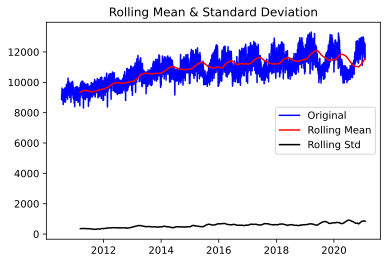

Results of Dickey-Fuller Test:
ADF Statistic                    -2.935432
p-value                           0.041380
#Lags Used                       30.000000
Number of Observations Used    3819.000000
Critical Value (1%)              -3.432063
Critical Value (5%)              -2.862297
Critical Value (10%)             -2.567173
dtype: float64


In [99]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=240).mean()
    rolstd = pd.Series(timeseries).rolling(window=240).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts_50_per)

In [ ]:
ts_log = np.log(ts2)
plt.plot(ts_log)
test_stationarity(ts_log)

In [ ]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
import seaborn as sns
import statsmodels.api as sm
#Decompose a time serie
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()